# Generování textu znakovou RNN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

import torch
import torch.nn.functional as F
from torch import nn

import ans

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru `data/headlines.txt`.

Z textu byly odstraněny háčky, čárky a všechny nestandardní znaky. Není tedy potřeba řešit kódování apod.

In [3]:
data = open('data/headlines.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [4]:
for i in range(10):
    print(i, random.choice(lines))

0 kvetiny ktere propujci zahrade lehkost
1 mladici si meli najit brigadu misto toho zalozili firmu na siti motylku
2 reditel prumyslovky kde zaci sikanovali ucitelku odstoupit nehodla
3 vyhovujici prace prijemna teplota v kancelari a fungujici technika
4 ruska a syrska armada se dva tydny pripravuji na utok proti radikalum v idlibu
5 bitva o eet koalicni finta na opozici muze skoncit u soudu
6 nakladni auto na jizni spojce zachvatily plameny
7 na plavce zautocil zralok muz ve vode vykrvacel
8 skandaly v umeni zatceni sochare gutfreunda
9 migranti se v kamionu smrti zacali dusit uz po pul hodine zaznelo u soudu


Sada znaků = náš slovník:

In [5]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Všimněme si, že první znak je `'\n'`. Ten použijeme jako stop znak, neboli speciální token, jenž bude označovat konec sekvence. Pokud tedy při postupném generování věty dojde na tento znak, proces zastavíme.

Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [6]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [7]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

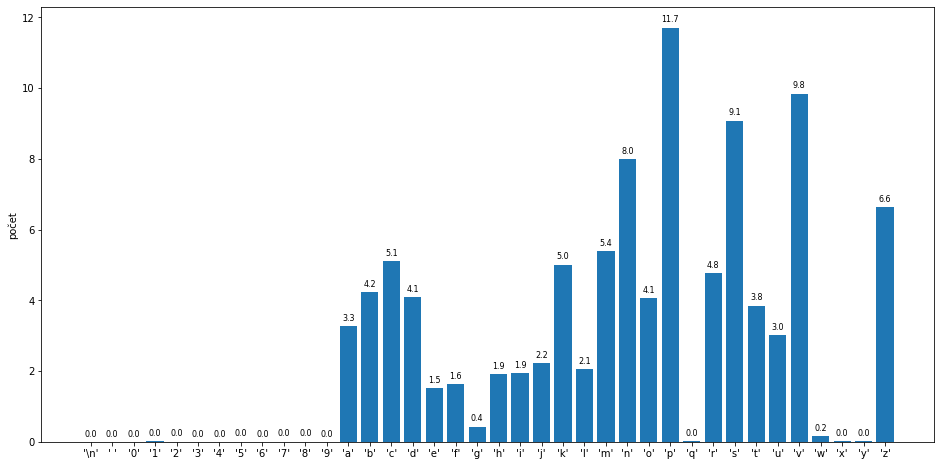

In [8]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet');

# Sekvenční data a PyTorch

## Embedding

Následující funkce `str2idt` převede řetězec na sekvenci čísel (index tensor) odpovídajících indexům znaků v tabulce. Pokud např. bude celý náš "slovník" `chars = ['a', 'b', 'c']`, pak funkce `str2idt` převede řetězec `'acba'` na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `torch.Tensor`.

In [9]:
def str2idt(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    return tensor

In [10]:
# nas slovnik ma 38 znaku, takze indexy znaku budou jine
x = str2idt('abca')
x

tensor([12, 13, 14, 12])

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [11]:
def idt2str(indices):
    return ''.join([chars[i] for i in indices])

In [12]:
idt2str(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [13]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e.shape

torch.Size([4, 30])

In [14]:
e

tensor([[ 9.5713e-01,  3.2152e-01,  1.2373e+00, -6.0046e-01, -1.2646e+00,
         -7.9618e-01, -2.0174e+00,  2.7264e+00, -1.5179e+00, -2.5308e-01,
          1.1939e+00,  1.6183e-02, -6.9193e-01, -5.5433e-01, -2.0585e-01,
         -1.0402e+00,  2.0226e+00,  1.3669e+00, -6.7868e-01,  8.2226e-01,
          7.5582e-01, -1.2763e+00,  2.8626e-01, -5.4145e-01, -2.1083e-01,
          7.2103e-01, -1.1048e-01, -1.3140e+00, -7.7129e-01,  1.4613e+00],
        [-3.5032e-01, -1.2149e+00,  2.1101e+00, -1.5627e+00,  8.7081e-01,
         -1.4698e+00,  2.8954e-02, -1.5634e+00, -9.3397e-01,  8.6608e-01,
          1.6495e+00,  7.4282e-02, -8.9063e-01, -3.8950e-01,  8.3725e-01,
         -6.1851e-01,  1.0450e+00,  2.8629e-01, -7.1776e-03, -5.4745e-01,
         -3.2270e+00,  6.7346e-01, -3.1327e+00, -6.3574e-01, -7.9184e-01,
          1.7462e+00,  4.5132e-01,  1.3831e-01,  4.2987e-01, -1.7795e+00],
        [ 6.2196e-01,  6.6377e-01, -4.8606e-01, -1.2685e-02,  2.4104e+00,
         -9.4174e-01, -5.0607e-01, -

`Embedding` nedělá nic jiného, než že na výstup pro znak s indexem $i$ vrátí $i$-tý řádek své váhové matice `weight`, která drží vektory slov. Defaultně je tato matice inicializována náhodně. Pokud první písmeno v příkladu bylo 'a', jehož index ve "slovníku" `chars` je 12, první řádek embeddingu `e` bude odpovídat 13. řádku (index 12) matice `emb.weight`.

In [15]:
bool(torch.all(e[0] == emb.weight[12]))

True

## RNN v PyTorch

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. To znamená, že `output` **neprochází žádnou lineární vrstvou**, jak jsme si to ukazovali na přednáškách, tedy že $y=W^{hy}h$, kde $y$ značí `output`. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami. Parametry $W^{hy}$ RNN v PyTorch nezahrnují.

Vstupní tensory $x_i$ na obrázku očekávají PyTorch RNN ve tvaru `(seq, batch, dim)`, kde
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

V našem případě jsou vstupy vektory (embeddingy) jednotlivých znaků. Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [16]:
# do site posleme pouze jeden znak; tvar tensoru musi byt (seq, batch, dim), proto musime pouzit reshape
e0 = e[0].reshape(1, 1, -1)
e0.shape

torch.Size([1, 1, 30])

Vytvoříme jednuduchou `torch.nn.RNN`, která na vstupu očekává vektor o rozměru 30 a bude mít skrytý vektor o rozměru 8.

In [17]:
rnn = nn.RNN(30, 8)
rnn

RNN(30, 8)

V PyTorch musíme řešit inicializaci i předávání skrytého stavu v jednotlivých krocích ručně. Umožňuje to tak větší flexibilitu.

In [18]:
# inicializace skryteho stavu a vstupu
# tensory opet musi byt tvaru (seq, batch, dim)
h = torch.rand(1, 1, 8)
h

tensor([[[0.7293, 0.2575, 0.0617, 0.5399, 0.4166, 0.1647, 0.5759, 0.7839]]])

In [19]:
# dopredny pruchod
o, h = rnn(e0, h)

RNN vrátí vždy dvojici `(output, hidden)`, které vysvětluje obrázek výše. V tomto jednoduchém případě, kdy máme pouze jedinou vrstvu, se jedná o tensory se shodnými hodnotami.

In [20]:
bool(torch.all(o == h))

True

Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků.

In [27]:
class CharRNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, num_layers=1):
        super(CharRNN, self).__init__()

        #################################################################
        # ZDE DOPLNIT
        
        self.voc_size = voc_size
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.emb = nn.Embedding(self.voc_size, self.emb_dim)
        self.rnn = nn.LSTM(self.emb_dim, self.hidden_size, num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        #################################################################

    def forward(self, x, hidden):
        
        #################################################################
        # ZDE DOPLNIT
        
        e = self.emb(x).reshape(1, 1, -1)
        
        out, hidden = self.rnn(e, hidden)
        score = self.fc(out)
        
        #################################################################
        
        return score, hidden

    def init_hidden(self):
        
        #################################################################
        # ZDE DOPLNIT
        # funkce vrati skryty vektor nainicalizovany na nuly
        
        hidden = (torch.zeros(self.num_layers, 1, self.hidden_size), 
                  torch.zeros(self.num_layers, 1, self.hidden_size))
        
        #################################################################
        
        return hidden

In [28]:
#################################################################
# ZDE DOPLNIT

voc_size = len(chars)
emb_dim = 100
hidden_dim = 100
output_dim = voc_size

#################################################################

rnn = CharRNN(voc_size, emb_dim, hidden_dim, output_dim, num_layers=1)
stats = ans.Stats()

Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme model `rnn` a nějaký inicializační text `init_text` a vygeneruje text - vrací tedy string.

In [33]:
def sample(rnn, init_text='', hidden=None, maxlen=150, mode='multinomial', temperature=0.6):
    """
    generuje text pomoci modelu `rnn`
    
    vstupy:
        rnn ... rekurentni sit odvozena z `nn.Module`, ktera po zavolani vraci dvojici (vyst_skore, skryta_rep)
        init_text ... inicializacni text, na ktery generovani textu navaze
        hidden ... inicializace skryte reprezentace
        maxlen ... maximalni delka generovaneho textu
        mode ... zpusob vyberu nasledujiciho znaku, viz komentare v kodu
        temperature ... vyhlazeni multinomialniho rozlozeni, viz komentare v kodu
    """
    # vystupni text bude pole (na konci prevedeme zpet na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        s = np.random.choice(len(chars), p=p0)
        out_text = [chars[s]]
    
    # vstup projedeme siti, abychom ziskali aktualni hidden stav
    hidden = rnn.init_hidden()        
    for i in range(len(out_text)):
        x = str2idt(out_text)
        score, hidden = rnn(x[i], hidden)
    
    
    # pravdepodobnosti muzeme pocitat softmaxem
    softmax = nn.Softmax(dim=2)

    while True:
        # nasledujici znak je posledni znak prozatimniho vystupu
        x = str2idt(out_text[-1])
        
        # dopredny pruchod
        score, hidden = rnn(x, hidden)
        
        # pravdepodobnosti znaku
        p = softmax(score).detach().numpy().squeeze()
        
        # vyberem index `k` nasleduciho znaku
        if mode == 'multinomial':
            # nasledujici znak bude vybran dle ad hoc multinomialniho rozlozeni
            # parametr `temperature` ... vyssi hodnota znamena nahodnejsi vysledky
            # viz https://github.com/karpathy/char-rnn#sampling
            k = torch.multinomial(score.view(-1).div(temperature).exp(), 1)[0]
        elif mode == 'argmax':
            #################################################################
            # ZDE DOPLNIT
            
            # nasledujici znak bude ten, jehoz pravdepodobnost vysla maximalni
            k = np.argmax(p)
            #################################################################
        elif mode == 'proportional':
            #################################################################
            # ZDE DOPLNIT
            
            # nasl. znak se vybere nahodne, ale s pravdepodobnosti proporcionalni k vystupu softmaxu
            # napr. pokud znak 'x' ma dle softmaxu 84 %, bude s pravdepodobnosti 84 % vybran jako vstup do dalsi iterace
            k = list(p).index(np.random.choice(p, p=p))
            
            #################################################################
        
        #################################################################
        # ZDE DOPLNIT
        
        # zastavit, pokud end-token
        if chars[k] == '\n':
            break
        
        # pridat znak na vystup
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if len(out_text) == maxlen:
            break
        
        # pripravit vstupni vektor `x` pro dalsi iteraci
        x = str2idt(out_text[-1])
        
        #################################################################
    
    return ''.join(out_text)

In [36]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidentpbdqldgwvs 2e fveed


# Trénování

V každé iteraci pomocí funkce `char_tensor` vytvoříme trénovací data `(inpt, targ)`, což budou číselné indexy znaků tak, jak je definuje tabulka `chr2idx`. Budeme trénovat generování znaků, tzn. že požadovaným výstupem (label, target) `targ[i]` pro vstup `inpt[i]` je vždy následující znak `inpt[i+1]`. Vektor `targ` je tedy v tomto případě stejného rozměru jako `inpt`. Nezapomeňte na poslední znak, který má jako target `\n` značící konec sekvence.

Vyzkoušejte si na příkladu:

In [37]:
line = random.choice(lines)
print(line)

recke ministerstvo financi hleda psy schopne vycenichat eura lide jich tam vybrali miliardy


In [38]:
#################################################################
# ZDE DOPLNIT

inpt = [chr2idx[ch] for ch in line]
targ = inpt[1:] + [chr2idx['\n']]

#################################################################

In [39]:
print('vstup:   {} ... {}'.format(idt2str(inpt[:10]), idt2str(inpt[-10:])))
print('target:  {} ... {}'.format(idt2str(targ[:10]), idt2str(targ[-10:])))

vstup:   recke mini ... i miliardy
target:  ecke minis ...  miliardy



In [40]:
criterion = nn.CrossEntropyLoss()

In [41]:
#################################################################
# ZDE DOPLNIT

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

#################################################################

In [42]:
stats = ans.Stats()

In [43]:
example = sample(rnn, mode='multinomial')
max_per_epoch = 1000

for epoch in range(10):
    # data budou nahodne prehazena
    train_ids = np.random.permutation(len(lines))[:max_per_epoch]

    # progressbar
    pb = tqdm.tqdm_notebook(train_ids, desc='ep {:03d}'.format(epoch))
    
    stats.new_epoch()
    
    for it, line in enumerate(pb):
        hidden = rnn.init_hidden()
        rnn.zero_grad()
        loss = 0.
    
        #################################################################
        # ZDE DOPLNIT
        
        inpt = [chr2idx[ch] for ch in lines[line]]
        targ = inpt[1:] + [chr2idx['\n']]
        
        for ic, c in enumerate(lines[line]):
            # dopredny pruchod pro `ic`-ty znak
            score, hidden = rnn(torch.tensor(inpt[ic]), hidden)
            loss += criterion(torch.squeeze(score, 0), torch.tensor([targ[ic]]))
        
        loss /= len(x)
        
        #################################################################

        loss.backward()
        optimizer.step()
        
        if it % 100 == 0:
            example = sample(rnn)
        
        stats.append_batch_stats('train', loss=float(loss))
        pb.set_postfix(loss='{:.3f}'.format(stats.ravg('train', 'loss')), ex=example[:40])
    
# pripadne ulozit model
torch.save(rnn.state_dict(), f'lstm-{epoch:02d}.pth')

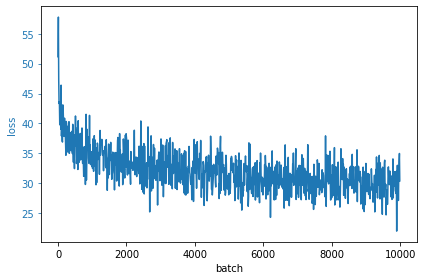

In [44]:
stats.plot_by_batch(block_len=10, right_metric=None)

In [51]:
rnn.eval()
for i in range(5):
    print(sample(rnn, init_text='prezi', mode='multinomial'))

prezine na prostav tady propati pudlou na priti pro zazavala v policici po met bude na silnich
prezineni policii stahna rodinou bez prozilni na hranicni nestovku o postaveni rok svetrane lodi nekolove alef ctvrtila rodina u soudce zaslanech miri
prezinu stane stovku volum pozarostili zavrazdu auto franci nezabil se nejvicic nekonce potrelice mohou se skuze byly se strelavitrami v policie
prezine stata ze havlickem dokula ban za rusko 30 lidi po vozna verci
prezisti na porbal velkou se znactil nejje zama ve zahazali stave s restuji vile plyne
